In [1]:
import weightwatcher as ww
import matplotlib.pyplot as plt
import numpy as np
import powerlaw

### This experiment is inspired by https://calculatedcontent.com/2018/09/14/power-laws-in-deep-learning-2-universality/

In [2]:
ww.__file__

'/home/ubuntu/test_ww/WeightWatcher2/WeightWatcher/weightwatcher/__init__.py'

In [3]:
def generate_pdfs(mu = 1):
    N, M = 1000, 500
    Q = N / M
    #W = np.random.normal(0,1,size=(M,N))
    W=np.random.pareto(mu,size=(N,M))
    # X shape is M x M
    X = (1/N)*np.dot(W.T,W)
    evals = np.linalg.eigvals(X)

    # This mimics the usual behavior of NNs, which do not have extremely large evals
    # One can change the constant here to see how the exponential truncation changes with the scale
    evals = evals/10000
    evals = evals[5:]
    
    return evals

### Test truncated powerlaw

In [ ]:
num_exps = 10
alphas_final = []
alphas_final_std = []
lambdas_final = []
lambdas_final_std = []
mu_list = np.linspace(1.0, 3.0, 20)

for mu in mu_list:
    alphas = []
    lambdas = []
    for exp in range(num_exps):
        evals = generate_pdfs(mu = mu)
        watcher = ww.WeightWatcher(model=None)
        alpha, xmin, xmax, D, sigma, num_pl_spikes, best_fit, exponent, sigma_var = \
            watcher.fit_powerlaw(evals, xmax = np.max(evals), plot=False, distribution='truncated_power_law')
        alphas.append(alpha)
        lambdas.append(exponent*xmin)
    alphas_final.append(np.mean(alphas))
    lambdas_final.append(np.mean(lambdas))
    alphas_final_std.append(np.std(alphas))
    lambdas_final_std.append(np.std(lambdas))

In [5]:
alphas_final = np.array(alphas_final)
lambdas_final = np.array(lambdas_final)
alphas_final_std = np.array(alphas_final_std)
lambdas_final_std = np.array(lambdas_final_std)

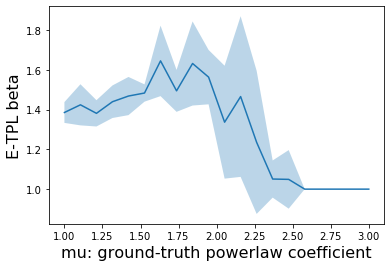

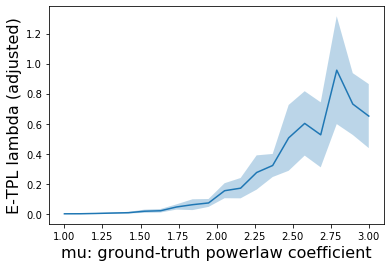

In [6]:
fig, ax = plt.subplots()
ax.plot(mu_list, alphas_final)
ax.set_xlabel("mu: ground-truth powerlaw coefficient", fontsize = 16)
ax.set_ylabel("E-TPL beta", fontsize = 16)
ax.fill_between(mu_list, alphas_final - alphas_final_std, alphas_final + alphas_final_std, alpha=0.3)

fig, ax = plt.subplots()
ax.plot(mu_list, lambdas_final)
ax.set_xlabel("mu: ground-truth powerlaw coefficient", fontsize = 16)
ax.set_ylabel("E-TPL lambda (adjusted)", fontsize = 16)
ax.fill_between(mu_list, lambdas_final - lambdas_final_std, lambdas_final + lambdas_final_std, alpha=0.3)


In [ ]:
num_exps = 10
alphas_final = []
alphas_final_std = []
mu_list = np.linspace(1.0, 3.0, 20)

for mu in mu_list:
    alphas = []
    lambdas = []
    for exp in range(num_exps):
        evals = generate_pdfs(mu = mu)
        watcher = ww.WeightWatcher(model=None)
        alpha, xmin, xmax, D, sigma, num_pl_spikes, best_fit, exponent, sigma_var = \
            watcher.fit_powerlaw(evals, xmax = np.max(evals), plot=False, distribution='power_law')
        alphas.append(alpha)
    alphas_final.append(np.mean(alphas))
    alphas_final_std.append(np.std(alphas))

In [8]:
alphas_final = np.array(alphas_final)
alphas_final_std = np.array(alphas_final_std)

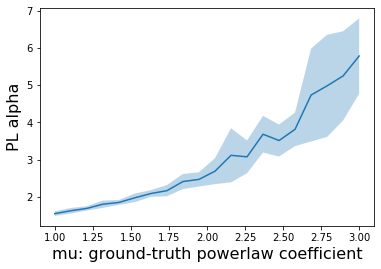

In [9]:
fig, ax = plt.subplots()
ax.plot(mu_list, alphas_final)
ax.set_xlabel("mu: ground-truth powerlaw coefficient", fontsize = 16)
ax.set_ylabel("PL alpha", fontsize = 16)
ax.fill_between(mu_list, alphas_final - alphas_final_std, alphas_final + alphas_final_std, alpha=0.3)

### Test the scale-freeness

In [ ]:
evals = generate_pdfs(mu = 1.5)
scale_alphas = []
scale_lambdas = []
scale_factors = [0.01, 0.1, 1.0, 10, 100]

for scale_factor in scale_factors:
    new_evals = evals*scale_factor
    watcher = ww.WeightWatcher(model=None)
    alpha, xmin, xmax, D, sigma, num_pl_spikes, best_fit, exponent, sigma_var = \
            watcher.fit_powerlaw(new_evals, xmax = np.max(new_evals), plot=False, distribution='truncated_power_law')
    scale_alphas.append(alpha)
    scale_lambdas.append(xmin*exponent)

Text(0.5, 0, 'Scale factors')

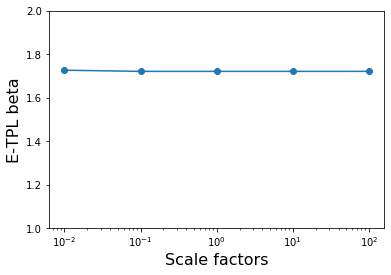

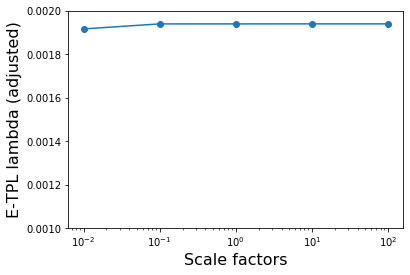

In [16]:
fig, ax = plt.subplots()
ax.semilogx(scale_factors, scale_alphas, 'o-')
ax.set_ylim([1,2])
ax.set_ylabel('E-TPL beta', fontsize = 16)
ax.set_xlabel('Scale factors', fontsize = 16)

fig, ax = plt.subplots()
ax.semilogx(scale_factors, scale_lambdas, 'o-')
ax.set_ylim([0.001,0.002])
ax.set_ylabel('E-TPL lambda (adjusted)', fontsize = 16)
ax.set_xlabel('Scale factors', fontsize = 16)

# Some conclusions here.

### 1. When the powerlaw distribution becomes less heavy-tail, beta is not monotone
### 2. The beta is something that does not change with scale. However, lambda changes with scale
### 3. If we use xmin* lambda, then it is scale-free (the first data point is because WW trims small evalues)